# Classifying satellite data <img align="right" src="../../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual)

## Description

Having succesfully run the `3_Evaluate_optimize_fit_classifier` notebook, we can now use our classification model to predict values on new satellite data.  This notebook will guide you through loading satellite data from the ODC, computing the same feature layers as we did in the first notebook when we extracted training data from the ODC, and using our model to classify the satellite data.  Initially we classify a few small regions to visualize how well our model is performing. The notebook will then attempt to classify a much larger region and save the results to disk as a Cloud-Optimized GeoTIFF (COG).

The steps are as follows:
1. Open the model we output in the previous notebook, `3_Evaluate_optimize_fit_classifier`
2. Redefine the feature layer function that we used to extract training data from the ODC in the first notebook, `1_Extract_training_data`
3. Loop through a set of small test locations extracting satellite data from the ODC, then compute the feature layers and classify the data using our model.
4. Plot the results of classifying our small test locations
5. Define a new, much larger location to load from the ODC and classify using the same model
6. Save our results to disk as a COG


***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import datacube
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.classification import predict_xr

import warnings
warnings.filterwarnings("ignore")


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [2]:
create_local_dask_cluster(spare_mem='2Gb')

Client Scheduler: tcp://127.0.0.1:34969 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 64.57 GB


## Analysis parameters

* `model_path`: The path to the location where the model exported from the previous notebook is stored
* `testing_locations`: A dictionary with values containing latitude and longitude points, and keys representing a unique ID to identify the locations. The `lat` and `lon` points define the center of the satellite images we will load for running small test classifications
* `buffer`: The size, in decimal degrees, to load around the central latitude and longitude points in `locations`. This number here will depend on the compute/RAM available on the Sandbox instance, and the type and number of feature layers calculated. A value of `0.1` (which results in a 0.2 x 0.2 degree analysis extent) usually works well on the default Sandbox instance. 
* `dask_chunks`: Dask works by breaking up large datasets into chunks, which can be read individually. This parameter specifies the size of the chunks in numbers of pixels, e.g. `{'x':1000,'y':1000}`
* `results`: A folder location to store the classified GeoTIFFs 

In [3]:
model_path = 'results/ml_model.joblib'

testing_locations = {
    '1': (24.4780, 33.0457),
    '2': (22.7712, 28.5223),
    '3': (30.3971, 30.7996),
    '4': (31.1751, 31.2221),
}

buffer = 0.1

dask_chunks = {'x':1000,'y':1000}

results = 'results/'

### Connect to the datacube

In [4]:
dc = datacube.Datacube(app='prediction')

## Import the model

The code below will also re-open the training data we exported from `3_Evaluate_optimize_fit_classifier.ipynb` and grab the column names (features we selected).

In [5]:
model = load(model_path)

## Making a prediction


### Redefining the feature layer function

Because we elected to use all the features extracted in `1_Extract_training_data.ipynb`, we can simply copy-and-paste the `feature_layers` function from the first notebook [Extracting_training_data](1_Extract_training_data.ipynb) into the cell below (this has already been done for you). 

If you're using this notebook to run your own classifications (i.e. not running the default example), then you'll need to redefine your feature layer function below, taking care to match the features in the trained model. For example, if you conducted feature selection and removed features from the model, then you'll need to mimic that process here by removing features in the prediction data. In short, the features in the model must precisely match those in the data you're classifying.

> **Note:** Because we are using dask to help us scale the operations, we need to add a `dask_chunks` parameter to the `slope` layer so this layer will interact with the dask arrays in the satellite data. As `slope` is a 2D layer, we don't need 'time' in the chunks argument, only 'x' and 'y'.

In [6]:
from datacube.testutils.io import rio_slurp_xarray

def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='feature_layers')
    
    #load ls8 geomedian
    ds = dc.load(product='gm_s2_annual',
                 **query)
    
    #calculate some band indices
    da = calculate_indices(ds,
                           index=['NDVI', 'LAI', 'MNDWI'],
                           drop=False,
                           collection='s2')
    
    #add slope dataset
    url_slope = "https://deafrica-data.s3.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif"
    slope = rio_slurp_xarray(url_slope, gbox=ds.geobox)
    slope = slope.to_dataset(name='slope').chunk(dask_chunks)
    
    #merge results into single dataset 
    result = xr.merge([da, slope],compat='override')

    return result.squeeze()

### Set up datacube query

These query options should match the query params in `1_Extract_training_data.ipynb`, unless there are measurements that no longer need to be loaded because they were dropped during a feature selection process (which has not been done in the default example).

In [7]:
# Set up the inputs for the ODC query
time = ('2019')
measurements =  ['blue','green','red','nir','swir_1','swir_2','red_edge_1',
                 'red_edge_2', 'red_edge_3', 'BCMAD', 'EMAD', 'SMAD']
resolution = (-20,20)
output_crs='epsg:6933'

### Loop through test locations and predict

For every location we listed in the `test_locations` dictionary, we calculate the feature layers, and then use the DE Africa function [predict_xr](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/83116e80ebb4f8744e3de74e7a713aadd0a7577a/Tools/deafrica_tools/classification.py#L237) to classify the data.

The `predict_xr` function is an xarray wrapper around the sklearn estimator `.predict()` and `.predict_proba()` methods, and relies on [dask-ml](https://ml.dask.org/) [ParallelPostfit](https://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html) to run the predictions with dask. `Predict_xr` can compute predictions, prediction probabilites, and return the input feature layers. Read the [documentation](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/83116e80ebb4f8744e3de74e7a713aadd0a7577a/Tools/deafrica_tools/classification.py#L247) for more insights into this function's capabilities.

In [8]:
predictions = []

for key, value in testing_locations.items():
    
    print('working on: ' + key)

     # generate a datacube query object
    query = {
        'x': (value[1]-buffer, value[1]+buffer),
        'y': (value[0]+buffer, value[0]-buffer),
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'dask_chunks' : dask_chunks,
    }

    #calculate features
    data = feature_layers(query)

    #predict using the imported model
    predicted = predict_xr(model,
                           data,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True
                          ).compute()
        
    predictions.append(predicted)
    

working on: 1
predicting...
   probabilities...
   input features...
working on: 2
predicting...
   probabilities...
   input features...
working on: 3
predicting...
   probabilities...
   input features...
working on: 4
predicting...
   probabilities...
   input features...


### Plotting results

In the plots below you'll see on the left the classified image (green = crop, white = non-crop), in the centre a true-colour image of the region, and on the right an image of the prediction probabilities. Because we are using a Random Forest Classifier, the prediction probabilities refer to the percentage of trees that voted for the resulting classification. For example, if the model had 200 decision trees in the random forest, and 150 of the trees voted 'crop', the prediction probability is **150 / 200 x 100 = 75 %**

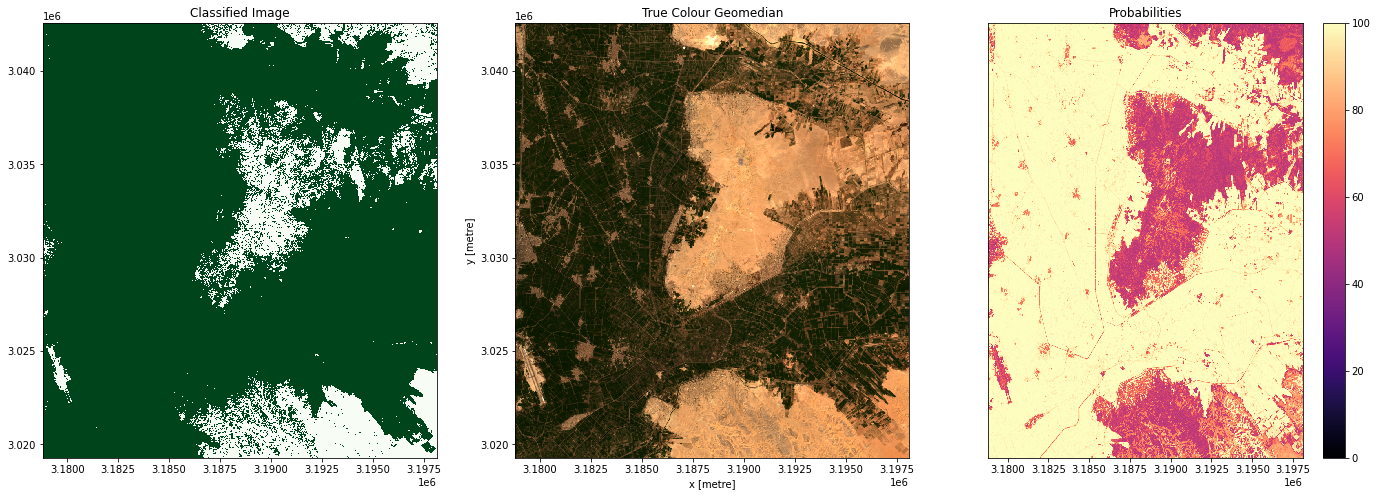

In [ ]:
for i in range(0, len(predictions)):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))


    # Plot classified image
    predictions[i].Predictions.plot(ax=axes[0], 
                   cmap='Greens', 
                   add_labels=False, 
                   add_colorbar=False)

    # Plot true colour image
    rgb(predictions[i], bands=['red','green','blue'],
        ax=axes[1], percentile_stretch=(0.01, 0.99))

    predictions[i].Probabilities.plot(ax=axes[2], 
                   cmap='magma',
                   vmin=0,
                   vmax=100,
                   add_labels=False, 
                   add_colorbar=True)

    # Remove axis on right plot
    axes[2].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('Classified Image')
    axes[1].set_title('True Colour Geomedian')
    axes[2].set_title('Probabilities');

## Large scale classification

If you're happy with the results of the test locations, then attempt to classify a large region by re-entering a new latitude, longitude and larger buffer size. You may need to adjust the `dask_chunks` size to optimize for the larger region. If you do change the chunk size, then remember to adjust the chunks in the feature layer function above (i.e. in the default example `feature_layers`)

The cell directly below will first clear the test location results from memory, so we have enough RAM to run a much larger prediction.  

In [ ]:
#clear objects from memory
del predictions
del predicted

Enter a new set of coordinates and larger buffer size below. You can use the `display_map()` cell to see an outline of the area you'll be classifying. The default example is centred on the city of Faiyum, Egypt.  Try to keep the buffer size below 0.5, any larger than this and the default sandbox will begin running out of RAM, which interrupts the calculation.

In [ ]:
new_lat, new_lon =  29.3037, 30.825 #centred on Faiyum, Egypt
buf_lat, buf_lon = 0.3, 0.5
dask_chunks={'x':1000,'y':1000}

In [ ]:
display_map((new_lon-buf_lon, new_lon+buf_lon), (new_lat+buf_lat, new_lat-buf_lat))

We will now classify the region specified above:

In [ ]:
# generate a datacube query object
query = {
    'x': (new_lon-buf_lon, new_lon+buf_lon),
    'y': (new_lat+buf_lat, new_lat-buf_lat),
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs,
    'dask_chunks' : dask_chunks,
}

# calculate features lazily
features = feature_layers(query)


#predict using the imported model
predicted = predict_xr(model,
                       features,
                       proba=True,
                       persist=True,
                       clean=True,
                       return_input=True).compute()


### Write the results to GeoTIFFs

Our predictions and prediction probabilites are written to disk as Cloud-Optimised GeoTIFFs.  In addition to exporting the predictions, we will also export one of the feature layers, NDVI. In the next notebook, `5_Object-based_filtering`, we will look at using image segmentation to clean up the pixel-based results. The NDVI layer will provide an input to the image segmentation algorithm.


In [ ]:
write_cog(predicted.Predictions, results+'prediction.tif', overwrite=True)
write_cog(predicted.Probabilities, results+'probabilities.tif', overwrite=True)
write_cog(predicted.NDVI, results+'NDVI.tif', overwrite=True)

### Plot the result

Below, we will plot our pixel based cropland mask for the region around the city of Faiyum, Egypt.

> **Note:** This could crash the kernel if the region is very large, but should be fine if you're using the default example.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='Greens', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
rgb(predicted,
        ax=axes[1], percentile_stretch=(0.01, 0.99))
    
predicted.Probabilities.plot(ax=axes[2], 
               cmap='magma',
               vmin=0,
               vmax=100,
               add_labels=False, 
               add_colorbar=True)

#Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

#Add plot titles
axes[0].set_title('Classified Image')
axes[1].set_title('True Colour Geomedian')
axes[2].set_title('Probabilities');

## Conclusions

Congratulations, you have successfully created a cropland extent model for Egypt! If you're perfectly happy with the results, then this pixel-based classification can be the final point in your workflow. However, in reality, ML workflows like the one you've just been through are an **iterative process**. If we weren't happy with the classifications, then we have a few options to improve the model:

1. Conduct feature selection to remove features that might be confounding our model.
2. Consider adding new features to the model. This would require editing and re-running the `collect_training_data` function in the [Extracting_training_data](1_Extract_training_data.ipynb) notebook to add new features to our training dataset.
3. Try using a different model (e.g. instead of using a Random Forest Classifier we could use a Support Vector Machine - this will require editing and re-running the [Evaluate_optimize_fit_classifier](3_Evaluate_optimize_fit_classifier.ipynb) notebook).
3. Collect more training data in the regions where our classifier is doing poorly. This can be done through the platforms suggested in [Extracting_training_data](1_Extract_training_data.ipynb).

We can also potentially improve our classifications by moving to the next notebook in this series. The next notebook explores converting the pixel-based classification into an object-based classification using an image segmentation algorithm.

## Recommended next steps

To continue working through the notebooks in this `Scalable Machine Learning on the ODC` workflow, go to the next notebook `5_Object-based_filtering.ipynb`.

1. [Extracting_training_data](1_Extract_training_data.ipynb)
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. [Evaluate_optimize_fit_classifier](3_Evaluate_optimize_fit_classifier.ipynb)
4. **Classify_satellite_data (this notebook)**
5. [Object-based_filtering](5_Object-based_filtering.ipynb)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')